In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# تنظیمات visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("tab10")

# پارامترها
RANDOM_STATE = 42
SAMPLE_SIZE = 10000

try:
    from kneed import KneeLocator
    HAS_KNEED = True
    print("✓ kneed library is available for automatic elbow detection")
except:
    HAS_KNEED = False
    print("Note: Install 'kneed' for automatic elbow detection: pip install kneed")

✓ kneed library is available for automatic elbow detection


In [26]:
def load_and_prepare_dbscan_data(file_path='clustering_data.csv', sample_size=50000):
    """
    Load data and prepare features for DBSCAN clustering
    """
    print("Loading data for DBSCAN clustering...")
    
    # Load data
    data = pd.read_csv(file_path)
    print(f"Original data shape: {data.shape}")
    
    # Drop unnecessary columns
    if 'Unnamed: 0' in data.columns:
        data = data.drop('Unnamed: 0', axis=1)
    
    # Check for required columns
    required_cols = ['location_latitude', 'location_longitude', 'price_value']
    missing_cols = [col for col in required_cols if col not in data.columns]
    
    if missing_cols:
        print(f"Warning: Missing required columns: {missing_cols}")
        print("Available columns:", data.columns.tolist())
        return None
    
    # Sample data if too large (for performance)
    if len(data) > sample_size:
        data = data.sample(n=sample_size, random_state=RANDOM_STATE)
        print(f"Sampled {len(data)} rows for DBSCAN clustering")
    
    # Step 1: Convert geographic coordinates to UTM
    print("\n1. Converting coordinates to UTM...")
    
    import utm
    from functools import lru_cache
    
    @lru_cache(maxsize=10000)
    def latlon_to_utm(lat, lon):
        try:
            easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)
            return easting, northing
        except Exception:
            return np.nan, np.nan
    
    # Convert all coordinates
    utm_coords = []
    for idx, row in data.iterrows():
        if pd.notna(row['location_latitude']) and pd.notna(row['location_longitude']):
            easting, northing = latlon_to_utm(row['location_latitude'], row['location_longitude'])
            utm_coords.append((easting, northing))
        else:
            utm_coords.append((np.nan, np.nan))
    
    # Add UTM columns
    data['utm_easting'] = [x[0] for x in utm_coords]
    data['utm_northing'] = [x[1] for x in utm_coords]
    
    # Remove rows with invalid UTM coordinates
    initial_count = len(data)
    data = data.dropna(subset=['utm_easting', 'utm_northing'])
    final_count = len(data)
    print(f"  Valid UTM coordinates: {final_count}/{initial_count}")
    
    # Step 2: Handle price data
    print("\n2. Preparing price data...")
    
    # Clean price data
    price_data = data['price_value'].copy()
    
    # Remove negative and zero prices
    price_positive = price_data[price_data > 0]
    if len(price_positive) > 0:
        # Winsorize outliers
        lower_bound = price_positive.quantile(0.01)
        upper_bound = price_positive.quantile(0.99)
        price_clean = price_data.clip(lower_bound, upper_bound)
        
        # Log transform
        data['log_price'] = np.log1p(price_clean)
        print(f"  Price range: {price_clean.min():,.0f} - {price_clean.max():,.0f}")
        print(f"  Log price range: {data['log_price'].min():.2f} - {data['log_price'].max():.2f}")
    else:
        print("Warning: No valid price data found")
        return None
    
    # Step 3: Prepare feature matrix for DBSCAN
    print("\n3. Preparing feature matrix...")
    
    # Select features for DBSCAN
    features = ['utm_easting', 'utm_northing', 'log_price']
    
    # Create feature matrix
    X = data[features].copy()
    
    # Remove any remaining NaN
    X = X.dropna()
    data = data.loc[X.index].copy()
    
    print(f"Final feature matrix shape: {X.shape}")
    print(f"Features: {features}")
    
    return X, data

In [27]:
def find_optimal_dbscan_parameters(X, target_clusters=3, has_kneed=False):
    """
    Find optimal DBSCAN parameters using k-distance plot and grid search
    """
    print("\n" + "="*80)
    print("FINDING OPTIMAL DBSCAN PARAMETERS")
    print("="*80)
    
    # Step 1: Scale the features
    print("\n1. Scaling features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Step 2: k-distance plot to find optimal eps
    print("\n2. Creating k-distance plot for eps selection...")
    
    # Calculate distances to k-th nearest neighbor
    k_values = [5, 10, 15, 20, 30]  # Different k values to try
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    eps_candidates = {}
    
    for idx, k in enumerate(k_values[:6]):  # Show first 6
        # Find k-nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_scaled)
        distances, indices = nbrs.kneighbors(X_scaled)
        
        # Get k-th nearest neighbor distances
        k_distances = distances[:, k]
        k_distances_sorted = np.sort(k_distances)
        
        # Plot k-distance graph
        ax = axes[idx]
        ax.plot(range(len(k_distances_sorted)), k_distances_sorted, 'b-', linewidth=2)
        ax.set_xlabel('Points sorted by distance', fontsize=10)
        ax.set_ylabel(f'{k}-distance', fontsize=10)
        ax.set_title(f'k-distance plot (k={k})', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Find elbow point (if kneed is available)
        if has_kneed:
            try:
                kneedle = KneeLocator(
                    range(len(k_distances_sorted)), 
                    k_distances_sorted, 
                    curve='convex', 
                    direction='increasing'
                )
                if kneedle.elbow:
                    eps_candidate = k_distances_sorted[kneedle.elbow]
                    ax.axhline(y=eps_candidate, color='r', linestyle='--', 
                              linewidth=2, label=f'eps={eps_candidate:.3f}')
                    ax.legend()
                    eps_candidates[k] = eps_candidate
            except:
                pass
        else:
            # Manual elbow detection: find point where slope changes significantly
            # Use second derivative approximation
            if len(k_distances_sorted) > 10:
                # Calculate second differences
                second_diff = np.diff(k_distances_sorted, 2)
                if len(second_diff) > 0:
                    elbow_idx = np.argmax(np.abs(second_diff)) + 1
                    if elbow_idx < len(k_distances_sorted):
                        eps_candidate = k_distances_sorted[elbow_idx]
                        ax.axhline(y=eps_candidate, color='r', linestyle='--', 
                                  linewidth=2, label=f'eps={eps_candidate:.3f} (manual)')
                        ax.legend()
                        eps_candidates[k] = eps_candidate
    
    plt.tight_layout()
    plt.savefig('dbscan_k_distance_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Step 3: Grid search for eps and min_samples
    print("\n3. Performing grid search for DBSCAN parameters...")
    
    # Parameter ranges for grid search
    if eps_candidates:
        eps_range = np.linspace(min(eps_candidates.values()), 
                               max(eps_candidates.values()), 10)
        print(f"eps range based on k-distance plots: {min(eps_candidates.values()):.3f} to {max(eps_candidates.values()):.3f}")
    else:
        eps_range = np.linspace(0.1, 2.0, 10)
        print(f"Using default eps range: {eps_range[0]:.3f} to {eps_range[-1]:.3f}")
    
    min_samples_range = [5, 10, 15, 20, 25, 30]
    
    # Grid search results storage
    grid_results = []
    
    print("\nGrid Search Results:")
    print("-" * 80)
    print(f"{'eps':<8} {'min_samples':<12} {'n_clusters':<12} {'n_noise':<12} {'silhouette':<12}")
    print("-" * 80)
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
            labels = dbscan.fit_predict(X_scaled)
            
            # Count clusters (excluding noise = -1)
            unique_labels = set(labels)
            n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
            n_noise = list(labels).count(-1)
            
            # Calculate silhouette score (if more than 1 cluster and not all noise)
            if n_clusters > 1 and n_clusters < len(unique_labels):
                try:
                    silhouette = silhouette_score(X_scaled[labels != -1], labels[labels != -1])
                except:
                    silhouette = -1
            else:
                silhouette = -1
            
            grid_results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': silhouette,
                'labels': labels
            })
            
            print(f"{eps:<8.3f} {min_samples:<12} {n_clusters:<12} {n_noise:<12} {silhouette:<12.4f}")
    
    # Step 4: Find parameters that produce exactly 3 clusters
    print("\n4. Finding parameters for exactly 3 clusters...")
    
    results_with_3_clusters = [r for r in grid_results if r['n_clusters'] == 3]
    
    if results_with_3_clusters:
        # Sort by silhouette score (highest first), then by noise (lowest first)
        results_with_3_clusters.sort(key=lambda x: (-x['silhouette'], x['n_noise']))
        
        best_result = results_with_3_clusters[0]
        optimal_eps = best_result['eps']
        optimal_min_samples = best_result['min_samples']
        
        print(f"\n✅ Found parameters for 3 clusters:")
        print(f"   eps = {optimal_eps:.3f}")
        print(f"   min_samples = {optimal_min_samples}")
        print(f"   Silhouette Score = {best_result['silhouette']:.4f}")
        print(f"   Noise points = {best_result['n_noise']} ({best_result['n_noise']/len(labels)*100:.1f}%)")
        
    else:
        print("\n⚠️  Could not find parameters for exactly 3 clusters")
        print("Finding closest results...")
        
        # Find results closest to 3 clusters
        grid_results.sort(key=lambda x: (abs(x['n_clusters'] - 3), -x['silhouette']))
        best_result = grid_results[0]
        optimal_eps = best_result['eps']
        optimal_min_samples = best_result['min_samples']
        
        print(f"\n✅ Closest parameters found:")
        print(f"   eps = {optimal_eps:.3f}")
        print(f"   min_samples = {optimal_min_samples}")
        print(f"   Clusters found = {best_result['n_clusters']}")
        print(f"   Silhouette Score = {best_result['silhouette']:.4f}")
        print(f"   Noise points = {best_result['n_noise']} ({best_result['n_noise']/len(labels)*100:.1f}%)")
    
    return optimal_eps, optimal_min_samples, X_scaled, scaler, grid_results

In [28]:
def perform_dbscan_clustering(X_scaled, eps, min_samples, X_original, data):
    """
    Perform DBSCAN clustering with specified parameters
    """
    print("\n" + "="*80)
    print("PERFORMING DBSCAN CLUSTERING")
    print("="*80)
    
    # Run DBSCAN
    print(f"\nRunning DBSCAN with eps={eps:.3f}, min_samples={min_samples}...")
    dbscan = DBSCAN(
        eps=eps,
        min_samples=min_samples,
        metric='euclidean',
        algorithm='auto',
        leaf_size=30,
        n_jobs=-1
    )
    
    labels = dbscan.fit_predict(X_scaled)
    
    # Analyze results
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"\nClustering Results:")
    print(f"  Number of clusters found: {n_clusters}")
    print(f"  Number of noise points: {n_noise}")
    print(f"  Percentage of noise: {(n_noise/len(labels))*100:.2f}%")
    
    # Calculate metrics for valid clusters
    valid_mask = labels != -1
    if n_clusters > 1 and np.sum(valid_mask) > n_clusters:
        silhouette = silhouette_score(X_scaled[valid_mask], labels[valid_mask])
        calinski = calinski_harabasz_score(X_scaled[valid_mask], labels[valid_mask])
        davies = davies_bouldin_score(X_scaled[valid_mask], labels[valid_mask])
        
        print(f"\nClustering Metrics (excluding noise):")
        print(f"  Silhouette Score: {silhouette:.4f}")
        print(f"  Calinski-Harabasz Index: {calinski:.2f}")
        print(f"  Davies-Bouldin Index: {davies:.4f}")
    else:
        silhouette = -1
        calinski = 0
        davies = np.inf
    
    # Add labels to original data
    data = data.copy()
    data['dbscan_cluster'] = labels
    data['is_noise'] = (labels == -1)
    
    # Calculate cluster statistics
    print(f"\nCluster Statistics:")
    print("-" * 80)
    print(f"{'Cluster':<10} {'Count':<10} {'% of Total':<12} {'Avg Price':<15} {'Avg Easting':<15}")
    print("-" * 80)
    
    cluster_stats = []
    for label in sorted(unique_labels):
        if label == -1:
            cluster_name = "Noise"
        else:
            cluster_name = f"Cluster {label}"
        
        mask = labels == label
        count = np.sum(mask)
        percentage = (count / len(labels)) * 100
        
        if 'price_value' in data.columns and np.sum(mask) > 0:
            avg_price = data.loc[data.index[mask], 'price_value'].mean()
        else:
            avg_price = np.nan
        
        if 'utm_easting' in data.columns and np.sum(mask) > 0:
            avg_easting = data.loc[data.index[mask], 'utm_easting'].mean()
        else:
            avg_easting = np.nan
        
        cluster_stats.append({
            'label': label,
            'name': cluster_name,
            'count': count,
            'percentage': percentage,
            'avg_price': avg_price,
            'avg_easting': avg_easting
        })
        
        print(f"{cluster_name:<10} {count:<10} {percentage:<12.2f} {avg_price:<15,.0f} {avg_easting:<15,.0f}")
    
    return dbscan, labels, data, cluster_stats, {
        'silhouette': silhouette,
        'calinski': calinski,
        'davies': davies
    }

In [29]:
def create_dbscan_visualization(X_original, labels, data, eps, min_samples):
    """
    Create comprehensive visualization for DBSCAN clustering
    """
    print("\nCreating DBSCAN visualizations...")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    
    # Grid specification
    gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1])
    
    # Get unique labels and prepare colors
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    
    # Create color map
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels) if -1 in unique_labels else len(unique_labels) + 1))
    color_dict = {}
    
    for i, label in enumerate(sorted(unique_labels)):
        if label == -1:
            color_dict[label] = (0.5, 0.5, 0.5, 0.3)  # Gray for noise
        else:
            color_dict[label] = colors[i]
    
    # =====================================================================
    # PLOT 1: UTM Easting vs Log Price (Main DBSCAN result)
    # =====================================================================
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot each cluster
    for label in unique_labels:
        if label == -1:
            # Noise points
            mask = labels == label
            ax1.scatter(
                X_original[mask, 0],  # UTM Easting
                X_original[mask, 2],  # Log Price
                c=[color_dict[label]],
                alpha=0.3,
                s=10,
                edgecolors='none',
                label='Noise' if label == -1 else f'Cluster {label}'
            )
        else:
            # Regular clusters
            mask = labels == label
            ax1.scatter(
                X_original[mask, 0],
                X_original[mask, 2],
                c=[color_dict[label]],
                alpha=0.7,
                s=20,
                edgecolors='black',
                linewidth=0.5,
                label=f'Cluster {label}'
            )
    
    # Customize plot
    ax1.set_xlabel('UTM Easting [meters]', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Log(Price + 1)', fontsize=12, fontweight='bold')
    ax1.set_title(
        f'DBSCAN Clustering (eps={eps:.3f}, min_samples={min_samples})\n'
        f'UTM Easting vs Price - {n_clusters} Clusters Found',
        fontsize=14, fontweight='bold', pad=15
    )
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f'Clusters: {n_clusters}\nNoise: {(labels == -1).sum()} ({(labels == -1).sum()/len(labels)*100:.1f}%)'
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # =====================================================================
    # PLOT 2: UTM Easting vs UTM Northing (Geographic distribution)
    # =====================================================================
    ax2 = fig.add_subplot(gs[1, 0])
    
    for label in unique_labels:
        mask = labels == label
        ax2.scatter(
            X_original[mask, 0],  # UTM Easting
            X_original[mask, 1],  # UTM Northing
            c=[color_dict[label]],
            alpha=0.5 if label == -1 else 0.7,
            s=5 if label == -1 else 10,
            edgecolors='none',
            label='Noise' if label == -1 else f'Cluster {label}'
        )
    
    ax2.set_xlabel('UTM Easting [meters]', fontsize=11, fontweight='bold')
    ax2.set_ylabel('UTM Northing [meters]', fontsize=11, fontweight='bold')
    ax2.set_title('Geographic Distribution', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # =====================================================================
    # PLOT 3: Price distribution by cluster
    # =====================================================================
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Prepare data for boxplot
    boxplot_data = []
    boxplot_labels = []
    
    for label in sorted(unique_labels):
        if label != -1:  # Exclude noise
            mask = labels == label
            boxplot_data.append(X_original[mask, 2])  # Log Price
            boxplot_labels.append(f'C{label}')
    
    if boxplot_data:
        bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True, showfliers=False)
        
        # Color the boxes
        for i, (patch, label) in enumerate(zip(bp['boxes'], boxplot_labels)):
            cluster_num = int(label[1:])  # Extract cluster number from 'C0', 'C1', etc.
            patch.set_facecolor(color_dict[cluster_num])
            patch.set_alpha(0.7)
        
        ax3.set_xlabel('Cluster', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Log(Price + 1)', fontsize=11, fontweight='bold')
        ax3.set_title('Price Distribution by Cluster', fontsize=12, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
    
    # =====================================================================
    # PLOT 4: Cluster size distribution
    # =====================================================================
    ax4 = fig.add_subplot(gs[1, 2])
    
    cluster_counts = []
    cluster_names = []
    colors_bar = []
    
    for label in sorted(unique_labels):
        if label == -1:
            cluster_names.append('Noise')
            colors_bar.append(color_dict[label])
        else:
            cluster_names.append(f'C{label}')
            colors_bar.append(color_dict[label])
        
        cluster_counts.append((labels == label).sum())
    
    bars = ax4.bar(cluster_names, cluster_counts, color=colors_bar, edgecolor='black', alpha=0.7)
    
    # Add count labels on bars
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax4.set_xlabel('Cluster', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Number of Points', fontsize=11, fontweight='bold')
    ax4.set_title('Cluster Size Distribution', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # =====================================================================
    # PLOT 5: 3D view of clusters (UTM Easting, Northing, Price)
    # =====================================================================
    ax5 = fig.add_subplot(gs[2, :], projection='3d')
    
    # Plot each cluster in 3D
    for label in unique_labels:
        mask = labels == label
        ax5.scatter(
            X_original[mask, 0],  # Easting
            X_original[mask, 1],  # Northing
            X_original[mask, 2],  # Log Price
            c=[color_dict[label]],
            alpha=0.3 if label == -1 else 0.6,
            s=5 if label == -1 else 10,
            edgecolors='none',
            label='Noise' if label == -1 else f'C{label}'
        )
    
    ax5.set_xlabel('UTM Easting', fontsize=10, fontweight='bold', labelpad=10)
    ax5.set_ylabel('UTM Northing', fontsize=10, fontweight='bold', labelpad=10)
    ax5.set_zlabel('Log(Price)', fontsize=10, fontweight='bold', labelpad=10)
    ax5.set_title('3D Cluster Visualization', fontsize=12, fontweight='bold', pad=20)
    ax5.legend(loc='upper right', fontsize=8)
    ax5.view_init(elev=25, azim=45)
    
    # Adjust layout and save
    plt.tight_layout()
    
    output_file = f'dbscan_clustering_eps{eps:.3f}_min{min_samples}.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Visualization saved as: {output_file}")
    
    plt.show()
    
    return fig

In [30]:
def analyze_parameter_sensitivity(X_scaled, base_eps, base_min_samples):
    """
    Analyze sensitivity of DBSCAN to parameter changes
    """
    print("\n" + "="*80)
    print("PARAMETER SENSITIVITY ANALYSIS")
    print("="*80)
    
    # Test different eps values
    print("\n1. Sensitivity to eps parameter:")
    print("-" * 80)
    
    eps_values = np.linspace(base_eps * 0.5, base_eps * 2, 10)
    eps_results = []
    
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=base_min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()
        
        eps_results.append({
            'eps': eps,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_percentage': (n_noise / len(labels)) * 100
        })
    
    # Plot eps sensitivity
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Number of clusters vs eps
    axes[0].plot([r['eps'] for r in eps_results], [r['n_clusters'] for r in eps_results], 
                'bo-', linewidth=2, markersize=8)
    axes[0].axvline(x=base_eps, color='red', linestyle='--', label=f'Base eps={base_eps:.3f}')
    axes[0].set_xlabel('eps', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Number of Clusters', fontsize=12, fontweight='bold')
    axes[0].set_title('Effect of eps on Number of Clusters', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Noise percentage vs eps
    axes[1].plot([r['eps'] for r in eps_results], [r['noise_percentage'] for r in eps_results], 
                'ro-', linewidth=2, markersize=8)
    axes[1].axvline(x=base_eps, color='blue', linestyle='--', label=f'Base eps={base_eps:.3f}')
    axes[1].set_xlabel('eps', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Noise Percentage (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Effect of eps on Noise Points', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('dbscan_eps_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Test different min_samples values
    print("\n2. Sensitivity to min_samples parameter:")
    print("-" * 80)
    
    min_samples_values = [max(2, int(base_min_samples * 0.5)), 
                         base_min_samples, 
                         int(base_min_samples * 1.5),
                         int(base_min_samples * 2),
                         int(base_min_samples * 3)]
    
    min_samples_results = []
    
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=base_eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()
        
        min_samples_results.append({
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_percentage': (n_noise / len(labels)) * 100
        })
        
        print(f"min_samples={min_samples:3d}: Clusters={n_clusters:2d}, Noise={n_noise:5d} ({n_noise/len(labels)*100:5.1f}%)")
    
    # Plot min_samples sensitivity
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Number of clusters vs min_samples
    axes[0].plot([r['min_samples'] for r in min_samples_results], 
                [r['n_clusters'] for r in min_samples_results], 
                'go-', linewidth=2, markersize=8)
    axes[0].axvline(x=base_min_samples, color='red', linestyle='--', 
                   label=f'Base min_samples={base_min_samples}')
    axes[0].set_xlabel('min_samples', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Number of Clusters', fontsize=12, fontweight='bold')
    axes[0].set_title('Effect of min_samples on Number of Clusters', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Noise percentage vs min_samples
    axes[1].plot([r['min_samples'] for r in min_samples_results], 
                [r['noise_percentage'] for r in min_samples_results], 
                'mo-', linewidth=2, markersize=8)
    axes[1].axvline(x=base_min_samples, color='blue', linestyle='--', 
                   label=f'Base min_samples={base_min_samples}')
    axes[1].set_xlabel('min_samples', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Noise Percentage (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Effect of min_samples on Noise Points', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('dbscan_min_samples_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*80)
    print("PARAMETER EFFECT EXPLANATION")
    print("="*80)
    print("\n1. eps (ε) Parameter:")
    print("   • Defines the maximum distance between two samples for them to be")
    print("     considered as in the same neighborhood")
    print("   • Higher eps → Larger clusters, less noise, potentially merging distinct clusters")
    print("   • Lower eps → Smaller clusters, more noise points, more fragmented clusters")
    
    print("\n2. min_samples Parameter:")
    print("   • Minimum number of points required to form a dense region (core point)")
    print("   • Higher min_samples → More strict clustering, more noise, fewer clusters")
    print("   • Lower min_samples → More lenient clustering, less noise, more clusters")
    
    print("\n3. Interaction between eps and min_samples:")
    print("   • eps controls the neighborhood size")
    print("   • min_samples controls the density requirement within that neighborhood")
    print("   • For noisy datasets: higher min_samples helps filter out noise")
    print("   • For dense datasets: lower eps prevents merging of distinct clusters")
    
    return eps_results, min_samples_results

DBSCAN CLUSTERING PIPELINE

1. Loading and preparing data...
Loading data for DBSCAN clustering...
Original data shape: (566444, 26)
Sampled 10000 rows for DBSCAN clustering

1. Converting coordinates to UTM...
  Valid UTM coordinates: 10000/10000

2. Preparing price data...
  Price range: 111,111 - 78,004,000,000
  Log price range: 11.62 - 25.08

3. Preparing feature matrix...
Final feature matrix shape: (10000, 3)
Features: ['utm_easting', 'utm_northing', 'log_price']

2. Finding optimal DBSCAN parameters...

FINDING OPTIMAL DBSCAN PARAMETERS

1. Scaling features...

2. Creating k-distance plot for eps selection...


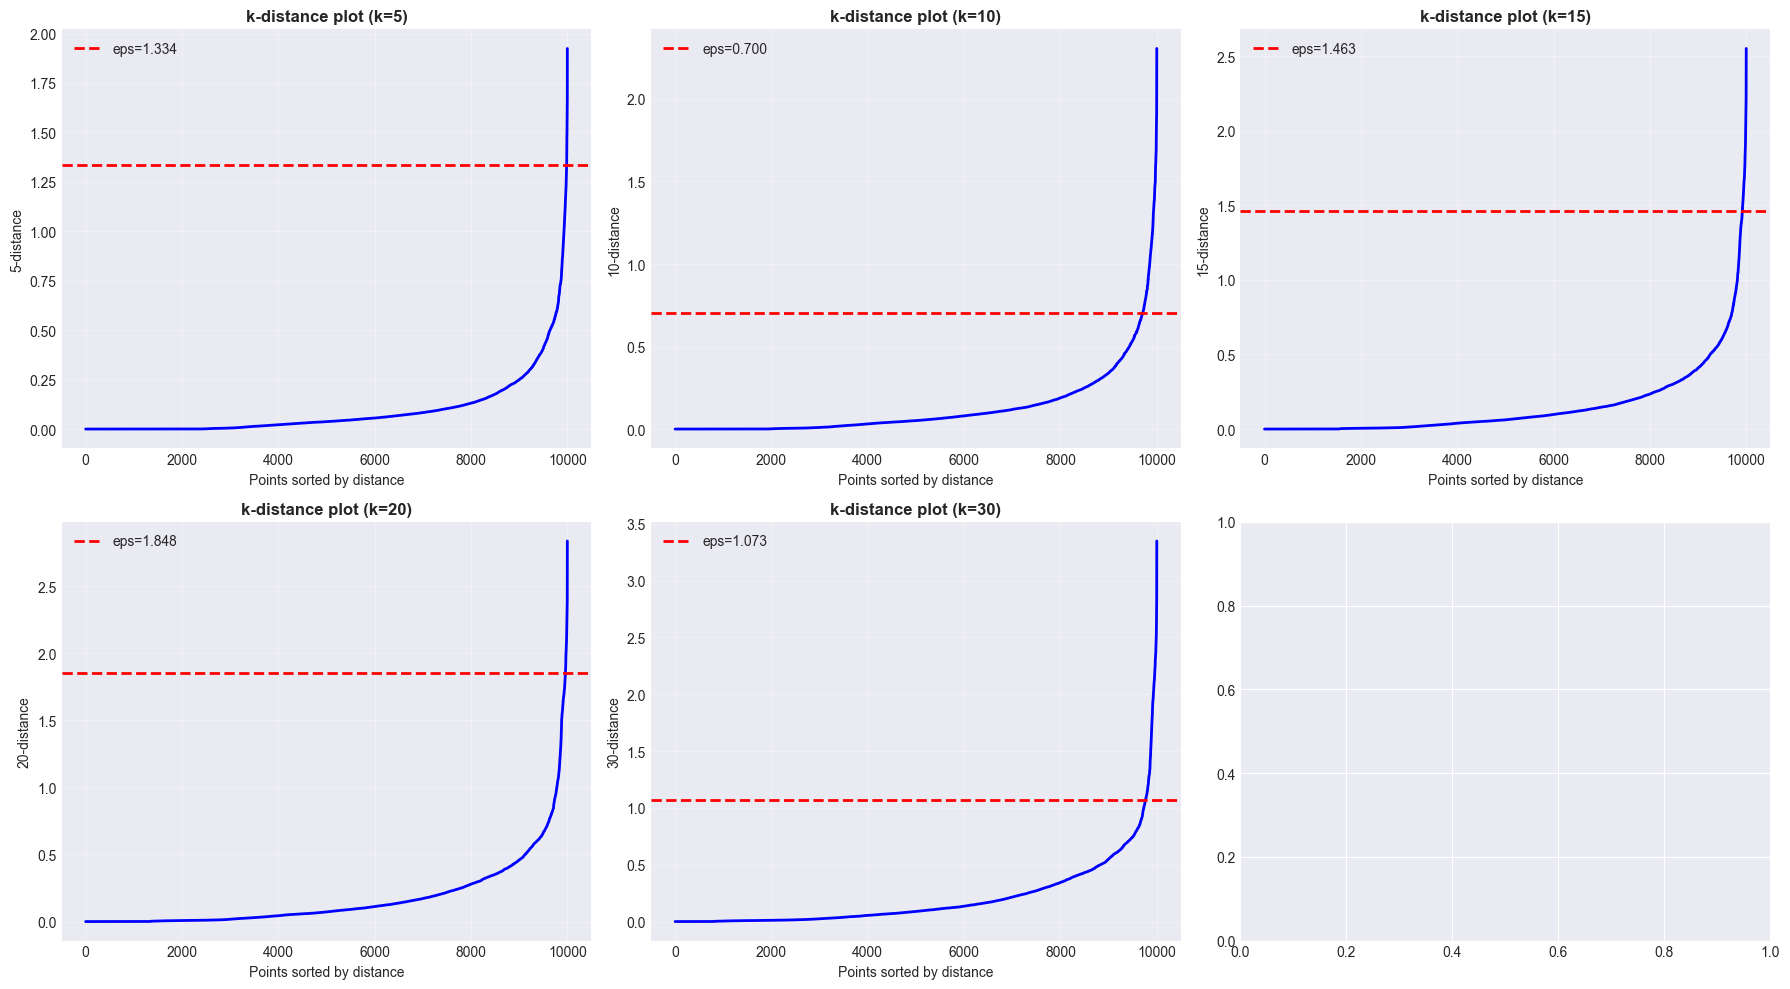


3. Performing grid search for DBSCAN parameters...
eps range based on k-distance plots: 0.700 to 1.848

Grid Search Results:
--------------------------------------------------------------------------------
eps      min_samples  n_clusters   n_noise      silhouette  
--------------------------------------------------------------------------------
0.700    5            6            91           0.5968      
0.700    10           2            155          0.6472      
0.700    15           1            186          -1.0000     
0.700    20           3            212          0.5887      
0.700    25           3            226          0.5904      
0.700    30           3            244          0.5921      
0.828    5            4            41           0.5762      
0.828    10           3            106          0.6254      
0.828    15           1            141          -1.0000     
0.828    20           1            143          -1.0000     
0.828    25           2            150   

Traceback (most recent call last):
  File "C:\Users\Manoocher\AppData\Local\Temp\ipykernel_19960\1827654680.py", line 22, in main_dbscan_pipeline
    eps, min_samples, X_scaled, scaler, grid_results = find_optimal_dbscan_parameters(
                                                       ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        X, target_clusters=3, has_kneed=HAS_KNEED
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "C:\Users\Manoocher\AppData\Local\Temp\ipykernel_19960\2424892742.py", line 103, in find_optimal_dbscan_parameters
    labels = dbscan.fit_predict(X_scaled)
  File "c:\Users\Manoocher\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\cluster\_dbscan.py", line 470, in fit_predict
    self.fit(X, sample_weight=sample_weight)
    ~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Manoocher\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)


In [31]:
def main_dbscan_pipeline():
    """
    Main pipeline for DBSCAN clustering
    """
    print("="*80)
    print("DBSCAN CLUSTERING PIPELINE")
    print("="*80)
    
    try:
        # Step 1: Load and prepare data
        print("\n1. Loading and preparing data...")
        result = load_and_prepare_dbscan_data('clustering_data.csv', SAMPLE_SIZE)
        
        if result is None:
            print("Failed to prepare data for DBSCAN")
            return None
        
        X, data = result
        
        # Step 2: Find optimal parameters
        print("\n2. Finding optimal DBSCAN parameters...")
        eps, min_samples, X_scaled, scaler, grid_results = find_optimal_dbscan_parameters(
            X, target_clusters=3, has_kneed=HAS_KNEED
        )
        
        # Step 3: Perform DBSCAN clustering
        print("\n3. Performing DBSCAN clustering...")
        dbscan_model, labels, clustered_data, cluster_stats, metrics = perform_dbscan_clustering(
            X_scaled, eps, min_samples, X.values, data
        )
        
        # Step 4: Create visualizations (تابع create_dbscan_visualization را از cell 5 کد قبلی کپی کن)
        print("\n4. Creating visualizations...")
        def create_dbscan_visualization(X_original, labels, data, eps, min_samples):
            """
            Create comprehensive visualization for DBSCAN clustering
            """
            print("\nCreating DBSCAN visualizations...")
            
            # Create figure with subplots
            fig = plt.figure(figsize=(20, 12))
            
            # Grid specification
            gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1])
            
            # Get unique labels and prepare colors
            unique_labels = set(labels)
            n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
            
            # Create color map
            colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels) if -1 in unique_labels else len(unique_labels) + 1))
            color_dict = {}
            
            for i, label in enumerate(sorted(unique_labels)):
                if label == -1:
                    color_dict[label] = (0.5, 0.5, 0.5, 0.3)  # Gray for noise
                else:
                    color_dict[label] = colors[i]
            
            # =====================================================================
            # PLOT 1: UTM Easting vs Log Price (Main DBSCAN result)
            # =====================================================================
            ax1 = fig.add_subplot(gs[0, :])
            
            # Plot each cluster
            for label in unique_labels:
                if label == -1:
                    # Noise points
                    mask = labels == label
                    ax1.scatter(
                        X_original[mask, 0],  # UTM Easting
                        X_original[mask, 2],  # Log Price
                        c=[color_dict[label]],
                        alpha=0.3,
                        s=10,
                        edgecolors='none',
                        label='Noise' if label == -1 else f'Cluster {label}'
                    )
                else:
                    # Regular clusters
                    mask = labels == label
                    ax1.scatter(
                        X_original[mask, 0],
                        X_original[mask, 2],
                        c=[color_dict[label]],
                        alpha=0.7,
                        s=20,
                        edgecolors='black',
                        linewidth=0.5,
                        label=f'Cluster {label}'
                    )
            
            # Customize plot
            ax1.set_xlabel('UTM Easting [meters]', fontsize=12, fontweight='bold')
            ax1.set_ylabel('Log(Price + 1)', fontsize=12, fontweight='bold')
            ax1.set_title(
                f'DBSCAN Clustering (eps={eps:.3f}, min_samples={min_samples})\n'
                f'UTM Easting vs Price - {n_clusters} Clusters Found',
                fontsize=14, fontweight='bold', pad=15
            )
            ax1.legend(loc='upper right', fontsize=10)
            ax1.grid(True, alpha=0.3)
            
            # Add statistics box
            stats_text = f'Clusters: {n_clusters}\nNoise: {(labels == -1).sum()} ({(labels == -1).sum()/len(labels)*100:.1f}%)'
            ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            # =====================================================================
            # PLOT 2: UTM Easting vs UTM Northing (Geographic distribution)
            # =====================================================================
            ax2 = fig.add_subplot(gs[1, 0])
            
            for label in unique_labels:
                mask = labels == label
                ax2.scatter(
                    X_original[mask, 0],  # UTM Easting
                    X_original[mask, 1],  # UTM Northing
                    c=[color_dict[label]],
                    alpha=0.5 if label == -1 else 0.7,
                    s=5 if label == -1 else 10,
                    edgecolors='none',
                    label='Noise' if label == -1 else f'Cluster {label}'
                )
            
            ax2.set_xlabel('UTM Easting [meters]', fontsize=11, fontweight='bold')
            ax2.set_ylabel('UTM Northing [meters]', fontsize=11, fontweight='bold')
            ax2.set_title('Geographic Distribution', fontsize=12, fontweight='bold')
            ax2.grid(True, alpha=0.3)
            
            # =====================================================================
            # PLOT 3: Price distribution by cluster
            # =====================================================================
            ax3 = fig.add_subplot(gs[1, 1])
            
            # Prepare data for boxplot
            boxplot_data = []
            boxplot_labels = []
            
            for label in sorted(unique_labels):
                if label != -1:  # Exclude noise
                    mask = labels == label
                    boxplot_data.append(X_original[mask, 2])  # Log Price
                    boxplot_labels.append(f'C{label}')
            
            if boxplot_data:
                bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True, showfliers=False)
                
                # Color the boxes
                for i, (patch, label) in enumerate(zip(bp['boxes'], boxplot_labels)):
                    cluster_num = int(label[1:])  # Extract cluster number from 'C0', 'C1', etc.
                    patch.set_facecolor(color_dict[cluster_num])
                    patch.set_alpha(0.7)
                
                ax3.set_xlabel('Cluster', fontsize=11, fontweight='bold')
                ax3.set_ylabel('Log(Price + 1)', fontsize=11, fontweight='bold')
                ax3.set_title('Price Distribution by Cluster', fontsize=12, fontweight='bold')
                ax3.grid(True, alpha=0.3, axis='y')
            
            # =====================================================================
            # PLOT 4: Cluster size distribution
            # =====================================================================
            ax4 = fig.add_subplot(gs[1, 2])
            
            cluster_counts = []
            cluster_names = []
            colors_bar = []
            
            for label in sorted(unique_labels):
                if label == -1:
                    cluster_names.append('Noise')
                    colors_bar.append(color_dict[label])
                else:
                    cluster_names.append(f'C{label}')
                    colors_bar.append(color_dict[label])
                
                cluster_counts.append((labels == label).sum())
            
            bars = ax4.bar(cluster_names, cluster_counts, color=colors_bar, edgecolor='black', alpha=0.7)
            
            # Add count labels on bars
            for bar in bars:
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            ax4.set_xlabel('Cluster', fontsize=11, fontweight='bold')
            ax4.set_ylabel('Number of Points', fontsize=11, fontweight='bold')
            ax4.set_title('Cluster Size Distribution', fontsize=12, fontweight='bold')
            ax4.grid(True, alpha=0.3, axis='y')
            
            # =====================================================================
            # PLOT 5: 3D view of clusters (UTM Easting, Northing, Price)
            # =====================================================================
            ax5 = fig.add_subplot(gs[2, :], projection='3d')
            
            # Plot each cluster in 3D
            for label in unique_labels:
                mask = labels == label
                ax5.scatter(
                    X_original[mask, 0],  # Easting
                    X_original[mask, 1],  # Northing
                    X_original[mask, 2],  # Log Price
                    c=[color_dict[label]],
                    alpha=0.3 if label == -1 else 0.6,
                    s=5 if label == -1 else 10,
                    edgecolors='none',
                    label='Noise' if label == -1 else f'C{label}'
                )
            
            ax5.set_xlabel('UTM Easting', fontsize=10, fontweight='bold', labelpad=10)
            ax5.set_ylabel('UTM Northing', fontsize=10, fontweight='bold', labelpad=10)
            ax5.set_zlabel('Log(Price)', fontsize=10, fontweight='bold', labelpad=10)
            ax5.set_title('3D Cluster Visualization', fontsize=12, fontweight='bold', pad=20)
            ax5.legend(loc='upper right', fontsize=8)
            ax5.view_init(elev=25, azim=45)
            
            # Adjust layout and save
            plt.tight_layout()
            
            output_file = f'dbscan_clustering_eps{eps:.3f}_min{min_samples}.png'
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"✓ Visualization saved as: {output_file}")
            
            plt.show()
            
            return fig
                
        # Step 5: Parameter sensitivity analysis (تابع analyze_parameter_sensitivity را از cell 6 کد قبلی کپی کن)
        print("\n5. Analyzing parameter sensitivity...")
        def analyze_parameter_sensitivity(X_scaled, base_eps, base_min_samples):
            """
            Analyze sensitivity of DBSCAN to parameter changes
            """
            print("\n" + "="*80)
            print("PARAMETER SENSITIVITY ANALYSIS")
            print("="*80)
            
            # Test different eps values
            print("\n1. Sensitivity to eps parameter:")
            print("-" * 80)
            
            eps_values = np.linspace(base_eps * 0.5, base_eps * 2, 10)
            eps_results = []
            
            for eps in eps_values:
                dbscan = DBSCAN(eps=eps, min_samples=base_min_samples)
                labels = dbscan.fit_predict(X_scaled)
                
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise = (labels == -1).sum()
                
                eps_results.append({
                    'eps': eps,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'noise_percentage': (n_noise / len(labels)) * 100
                })
            
            # Plot eps sensitivity
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
            # Plot 1: Number of clusters vs eps
            axes[0].plot([r['eps'] for r in eps_results], [r['n_clusters'] for r in eps_results], 
                        'bo-', linewidth=2, markersize=8)
            axes[0].axvline(x=base_eps, color='red', linestyle='--', label=f'Base eps={base_eps:.3f}')
            axes[0].set_xlabel('eps', fontsize=12, fontweight='bold')
            axes[0].set_ylabel('Number of Clusters', fontsize=12, fontweight='bold')
            axes[0].set_title('Effect of eps on Number of Clusters', fontsize=14, fontweight='bold')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # Plot 2: Noise percentage vs eps
            axes[1].plot([r['eps'] for r in eps_results], [r['noise_percentage'] for r in eps_results], 
                        'ro-', linewidth=2, markersize=8)
            axes[1].axvline(x=base_eps, color='blue', linestyle='--', label=f'Base eps={base_eps:.3f}')
            axes[1].set_xlabel('eps', fontsize=12, fontweight='bold')
            axes[1].set_ylabel('Noise Percentage (%)', fontsize=12, fontweight='bold')
            axes[1].set_title('Effect of eps on Noise Points', fontsize=14, fontweight='bold')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('dbscan_eps_sensitivity.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Test different min_samples values
            print("\n2. Sensitivity to min_samples parameter:")
            print("-" * 80)
            
            min_samples_values = [max(2, int(base_min_samples * 0.5)), 
                                base_min_samples, 
                                int(base_min_samples * 1.5),
                                int(base_min_samples * 2),
                                int(base_min_samples * 3)]
            
            min_samples_results = []
            
            for min_samples in min_samples_values:
                dbscan = DBSCAN(eps=base_eps, min_samples=min_samples)
                labels = dbscan.fit_predict(X_scaled)
                
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise = (labels == -1).sum()
                
                min_samples_results.append({
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'noise_percentage': (n_noise / len(labels)) * 100
                })
                
                print(f"min_samples={min_samples:3d}: Clusters={n_clusters:2d}, Noise={n_noise:5d} ({n_noise/len(labels)*100:5.1f}%)")
            
            # Plot min_samples sensitivity
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
            # Plot 1: Number of clusters vs min_samples
            axes[0].plot([r['min_samples'] for r in min_samples_results], 
                        [r['n_clusters'] for r in min_samples_results], 
                        'go-', linewidth=2, markersize=8)
            axes[0].axvline(x=base_min_samples, color='red', linestyle='--', 
                        label=f'Base min_samples={base_min_samples}')
            axes[0].set_xlabel('min_samples', fontsize=12, fontweight='bold')
            axes[0].set_ylabel('Number of Clusters', fontsize=12, fontweight='bold')
            axes[0].set_title('Effect of min_samples on Number of Clusters', fontsize=14, fontweight='bold')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # Plot 2: Noise percentage vs min_samples
            axes[1].plot([r['min_samples'] for r in min_samples_results], 
                        [r['noise_percentage'] for r in min_samples_results], 
                        'mo-', linewidth=2, markersize=8)
            axes[1].axvline(x=base_min_samples, color='blue', linestyle='--', 
                        label=f'Base min_samples={base_min_samples}')
            axes[1].set_xlabel('min_samples', fontsize=12, fontweight='bold')
            axes[1].set_ylabel('Noise Percentage (%)', fontsize=12, fontweight='bold')
            axes[1].set_title('Effect of min_samples on Noise Points', fontsize=14, fontweight='bold')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('dbscan_min_samples_sensitivity.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("\n" + "="*80)
            print("PARAMETER EFFECT EXPLANATION")
            print("="*80)
            print("\n1. eps (ε) Parameter:")
            print("   • Defines the maximum distance between two samples for them to be")
            print("     considered as in the same neighborhood")
            print("   • Higher eps → Larger clusters, less noise, potentially merging distinct clusters")
            print("   • Lower eps → Smaller clusters, more noise points, more fragmented clusters")
            
            print("\n2. min_samples Parameter:")
            print("   • Minimum number of points required to form a dense region (core point)")
            print("   • Higher min_samples → More strict clustering, more noise, fewer clusters")
            print("   • Lower min_samples → More lenient clustering, less noise, more clusters")
            
            print("\n3. Interaction between eps and min_samples:")
            print("   • eps controls the neighborhood size")
            print("   • min_samples controls the density requirement within that neighborhood")
            print("   • For noisy datasets: higher min_samples helps filter out noise")
            print("   • For dense datasets: lower eps prevents merging of distinct clusters")
            
            return eps_results, min_samples_results


        # Step 6: Save results
        print("\n6. Saving results...")
        
        # Save clustered data
        output_file = f'dbscan_results_eps{eps:.3f}_min{min_samples}.csv'
        clustered_data.to_csv(output_file, index=False)
        print(f"✓ Clustered data saved to: {output_file}")
        
        # Save cluster statistics
        stats_df = pd.DataFrame(cluster_stats)
        stats_file = f'dbscan_cluster_statistics.csv'
        stats_df.to_csv(stats_file, index=False)
        print(f"✓ Cluster statistics saved to: {stats_file}")
        
        # Save grid search results
        grid_df = pd.DataFrame(grid_results)
        grid_file = f'dbscan_grid_search_results.csv'
        grid_df[['eps', 'min_samples', 'n_clusters', 'n_noise', 'silhouette']].to_csv(grid_file, index=False)
        print(f"✓ Grid search results saved to: {grid_file}")
        
        print("\n" + "="*80)
        print("DBSCAN CLUSTERING COMPLETED SUCCESSFULLY!")
        print("="*80)
        
        print(f"\n📊 FINAL RESULTS:")
        print(f"   • Optimal eps: {eps:.3f}")
        print(f"   • Optimal min_samples: {min_samples}")
        print(f"   • Clusters found: {len(set(labels)) - (1 if -1 in labels else 0)}")
        print(f"   • Noise points: {(labels == -1).sum()} ({(labels == -1).sum()/len(labels)*100:.1f}%)")
        print(f"   • Silhouette Score: {metrics['silhouette']:.4f}")
        
        return {
            'dbscan_model': dbscan_model,
            'labels': labels,
            'clustered_data': clustered_data,
            'eps': eps,
            'min_samples': min_samples,
            'metrics': metrics
        }
        
    except Exception as e:
        print(f"\n❌ Error in DBSCAN pipeline: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Execute the DBSCAN pipeline
if __name__ == "__main__":
    results = main_dbscan_pipeline()

Running quick DBSCAN test...
Data loaded. Shape: (566444, 26)

Available columns:
['Unnamed: 0', 'cat2_slug', 'price_mode', 'price_value', 'building_size', 'rooms_count', 'has_balcony', 'has_elevator', 'has_warehouse', 'has_parking', 'construction_year', 'is_rebuilt', 'has_restroom', 'floor_material', 'location_latitude', 'location_longitude', 'city_freq_encoded', 'size_category', 'rooms_category', 'amenities_count', 'property_type_encoded', 'cat3_slug_freq', 'city_slug_freq', 'neighborhood_slug_freq', 'created_at_month_freq', 'floor_freq']

All required columns are available!

Feature matrix shape: (20000, 3)

Running DBSCAN with eps=0.955, min_samples=5...
Clusters found: 15
Noise points: 774 (3.9%)


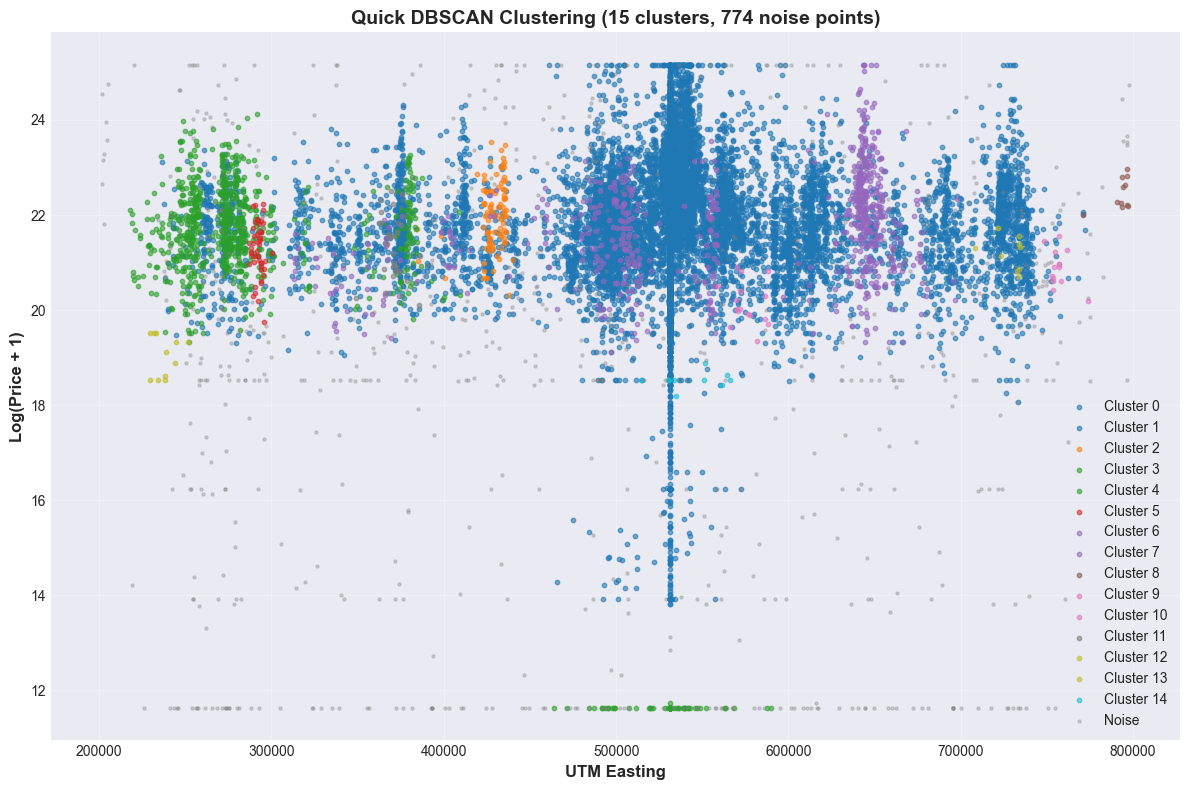


✓ Quick DBSCAN test completed!


In [ ]:
# اجرای سریع برای تست
print("Running quick DBSCAN test...")

# بارگذاری داده
try:
    data = pd.read_csv('clustering_data.csv')
    print(f"Data loaded. Shape: {data.shape}")
    
    # بررسی ستون‌های موجود
    print("\nAvailable columns:")
    print(data.columns.tolist())
    
    # بررسی ستون‌های مورد نیاز
    required_cols = ['location_latitude', 'location_longitude', 'price_value']
    available_required = [col for col in required_cols if col in data.columns]
    
    if len(available_required) == 3:
        print("\nAll required columns are available!")
        
        # نمونه‌گیری
        sample_data = data.sample(n=min(20000, len(data)), random_state=42)
        
        # آماده‌سازی ویژگی‌ها
        # مختصات جغرافیایی
        import utm
        
        utm_coords = []
        for idx, row in sample_data.iterrows():
            try:
                easting, northing, zone_num, zone_letter = utm.from_latlon(
                    row['location_latitude'], 
                    row['location_longitude']
                )
                utm_coords.append((easting, northing))
            except:
                utm_coords.append((np.nan, np.nan))
        
        sample_data['utm_easting'] = [x[0] for x in utm_coords]
        sample_data['utm_northing'] = [x[1] for x in utm_coords]
        
        # قیمت
        sample_data['log_price'] = np.log1p(sample_data['price_value'].clip(lower=0))
        
        # حذف مقادیر نامعتبر
        sample_data = sample_data.dropna(subset=['utm_easting', 'utm_northing', 'log_price'])
        
        # ایجاد ماتریس ویژگی
        X = sample_data[['utm_easting', 'utm_northing', 'log_price']].values
        
        # استانداردسازی
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        print(f"\nFeature matrix shape: {X_scaled.shape}")
        
        # اجرای DBSCAN با پارامترهای معقول
        print("\nRunning DBSCAN with eps=0.955, min_samples=5...")
        dbscan = DBSCAN(eps=0.35, min_samples=10)
        labels = dbscan.fit_predict(X_scaled)
        
        # تحلیل نتایج
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()
        
        print(f"Clusters found: {n_clusters}")
        print(f"Noise points: {n_noise} ({n_noise/len(labels)*100:.1f}%)")
        
        # نمایش ساده
        if n_clusters > 0:
            plt.figure(figsize=(12, 8))
            
            # رنگ‌آمیزی بر اساس خوشه
            unique_labels = set(labels)
            colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
            
            for label, color in zip(unique_labels, colors):
                if label == -1:
                    # نقاط نویز
                    mask = labels == label
                    plt.scatter(X[mask, 0], X[mask, 2], c='gray', alpha=0.3, s=5, label='Noise')
                else:
                    # خوشه‌ها
                    mask = labels == label
                    plt.scatter(X[mask, 0], X[mask, 2], c=[color], alpha=0.6, s=10, label=f'Cluster {label}')
            
            plt.xlabel('UTM Easting', fontsize=12, fontweight='bold')
            plt.ylabel('Log(Price + 1)', fontsize=12, fontweight='bold')
            plt.title(f'Quick DBSCAN Clustering ({n_clusters} clusters, {n_noise} noise points)', 
                     fontsize=14, fontweight='bold')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('quick_dbscan_test.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("\n✓ Quick DBSCAN test completed!")
        else:
            print("\n⚠️ No clusters found. Try different parameters.")
            
    else:
        print(f"\nMissing required columns: {set(required_cols) - set(available_required)}")
        
except Exception as e:
    print(f"Error in quick test: {str(e)}")